# EDA on augmented data

In [45]:
# Open swiss data GeoDataFrame
import geopandas as gpd
import pandas as pd

file_path = '../../data/processed/processed_enhanced_data_with_presence.csv'

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf.set_crs(epsg=2056, inplace=True)
gdf.set_index("idx", inplace=True)

gdf.head()

,geometry,Altitude,NaturalHabitat,SoilType,WaterRetention,NutrientContent,WaterPermeability,Temperature,Presence,Count
idx,,,,,,,,,,
35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3,0,0


In [46]:
gdf = gdf.drop(columns=['geometry', 'Count'])

In [47]:
gdf['Altitude'] = gdf['Altitude'].astype(float)
gdf['Temperature'] = gdf['Temperature'].astype(float)

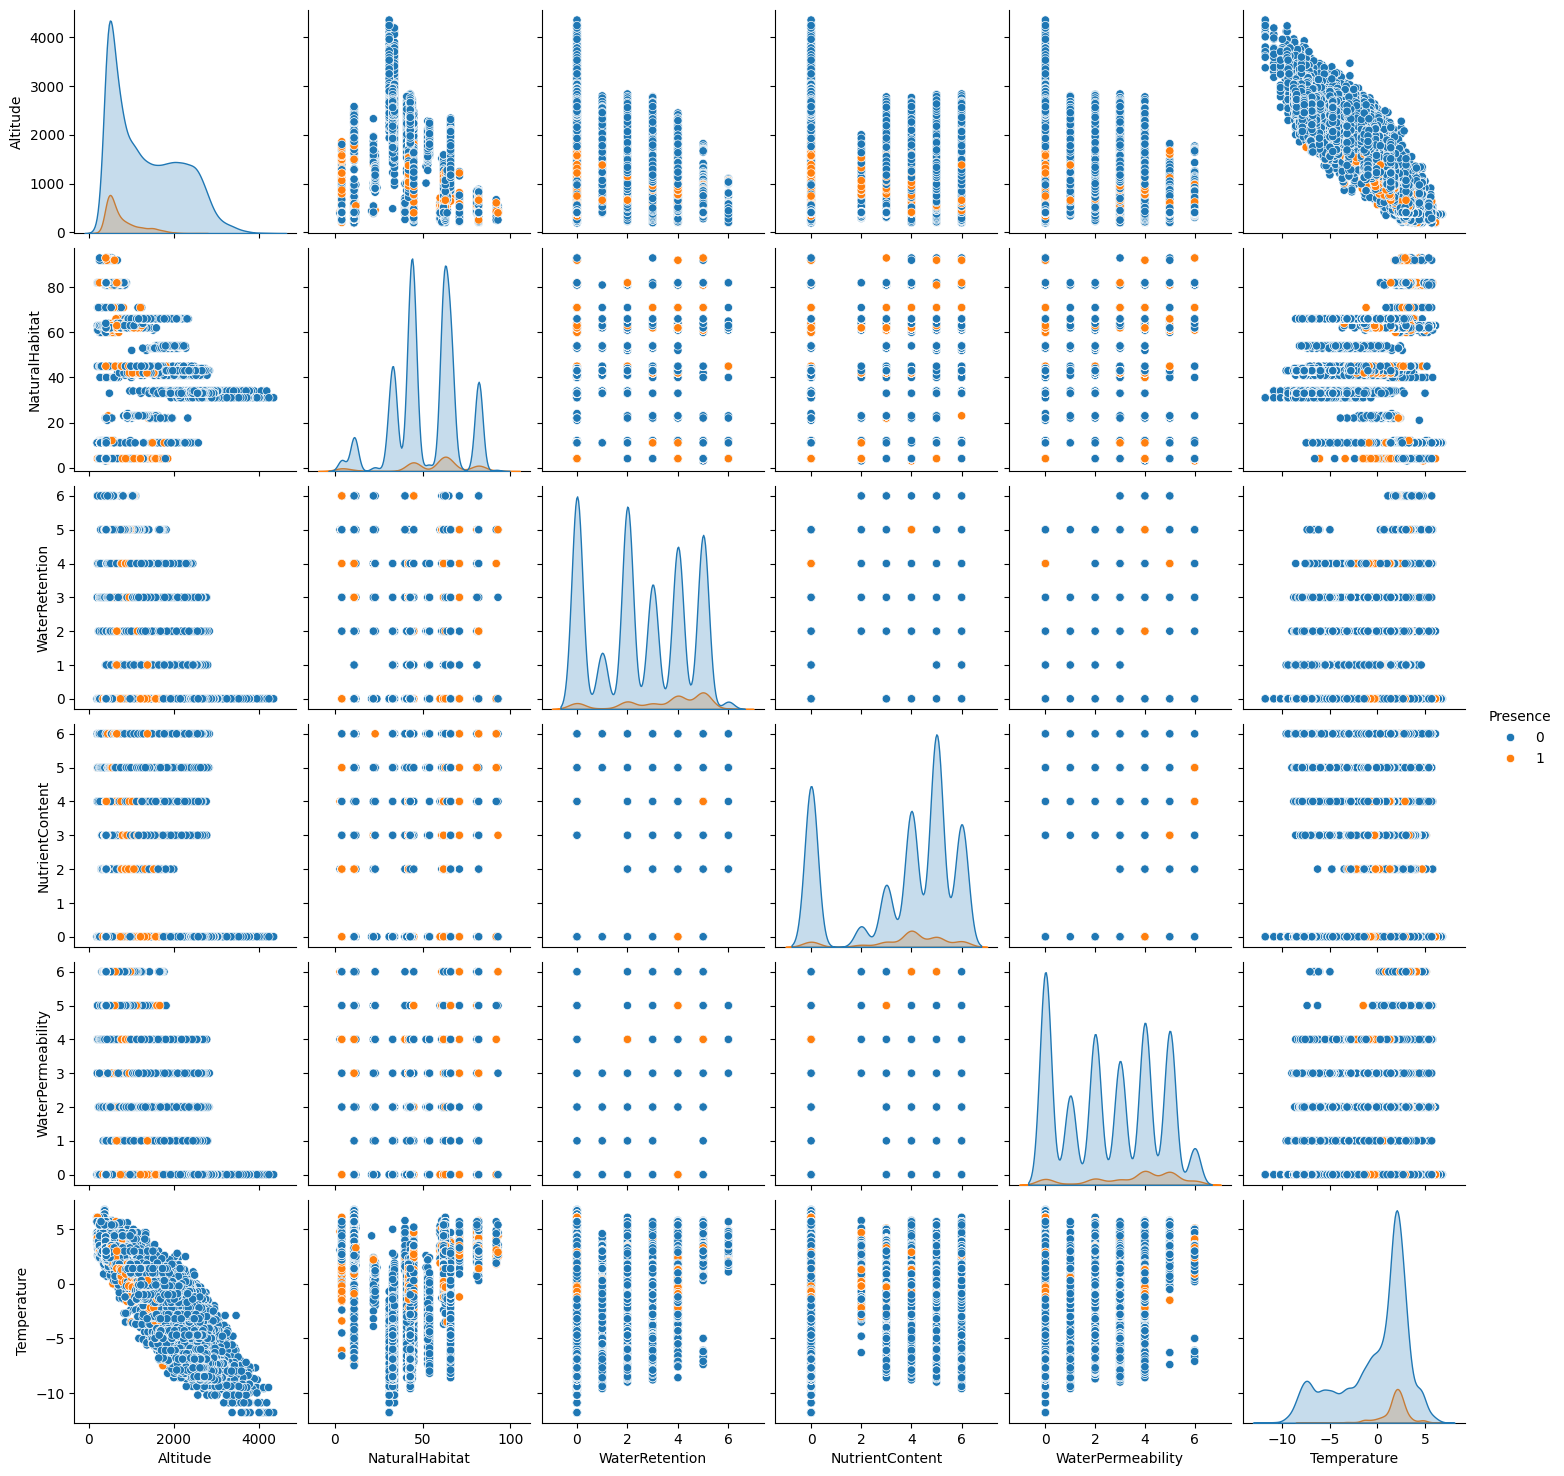

In [49]:
import seaborn as sns

sns.pairplot(gdf, hue='Presence')

In [60]:
import matplotlib.pyplot as plt

def bar_plot_with_categories(gdf, translation, feature_name, k=0):
    # Filtrer la table de traduction pour la caractéristique spécifiée
    feature_translation = translation[translation['Feature'] == feature_name]
    
    # Fusionner les données principales avec la table de traduction
    gdf_merged = gdf.merge(feature_translation, how='left', left_on=feature_name, right_on='Value')
    
    # Créer une table pivotée pour avoir les catégories en index et les valeurs de présence empilées
    counts_pivot = gdf_merged.groupby(['Category', 'Presence']).size().unstack(fill_value=0)
    
    # Ordonner les catégories par leur valeur d'origine
    ordered_categories = feature_translation.sort_values(by='Value')['Category']
    counts_pivot = counts_pivot.reindex(ordered_categories, fill_value=0)
    
    # Calculer la somme des valeurs (Presence=0 + Presence=1) pour chaque catégorie
    counts_pivot['Total'] = counts_pivot.sum(axis=1)
    
    # Filtrer les catégories dont la somme des valeurs est supérieure à k
    counts_pivot_filtered = counts_pivot[counts_pivot['Total'] > k]
    
    # Tracer l'histogramme empilé uniquement pour les catégories filtrées
    plt.figure(figsize=(10, 7))
    counts_pivot_filtered.drop(columns='Total').plot(kind='bar', stacked=True)
    
    plt.xlabel('Catégories')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des catégories {feature_name} en fonction de la présence (Frequence > {k})')
    plt.xticks(rotation=45)
    plt.legend(title='Presence', labels=['Presence = 0', 'Presence = 1'])
    plt.tight_layout()
    plt.show()


In [51]:
tranlation_path = '../../data/processed/translation_table.csv'

data = pd.read_csv(tranlation_path)
translation = pd.DataFrame(data)
translation.head()

,Unnamed: 0,Feature,Value,Category
0,0,NaturalHabitat,11,1.1 Eaux calmes
1,1,NaturalHabitat,12,1.2 Eaux courantes
2,2,NaturalHabitat,13,1.3 Sources et suintements
3,3,NaturalHabitat,14,1.4 Eaux souterraines
4,4,NaturalHabitat,20,2.0 Rives artificielles


<Figure size 1000x700 with 0 Axes>

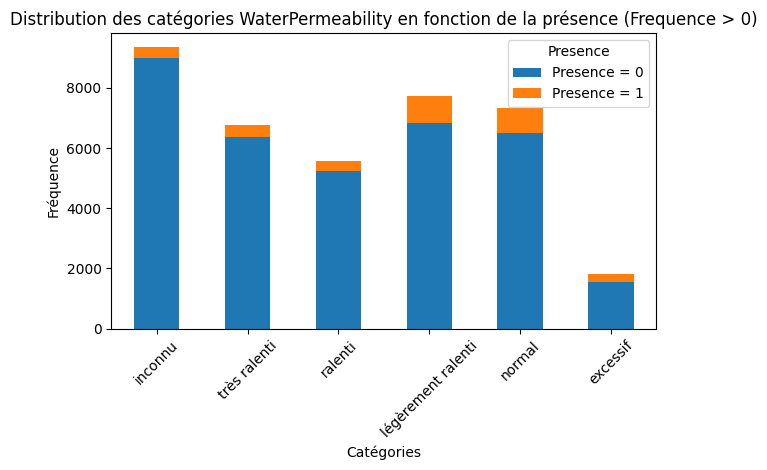

In [61]:
bar_plot_with_categories(gdf, translation, 'WaterPermeability')

<Figure size 1000x700 with 0 Axes>

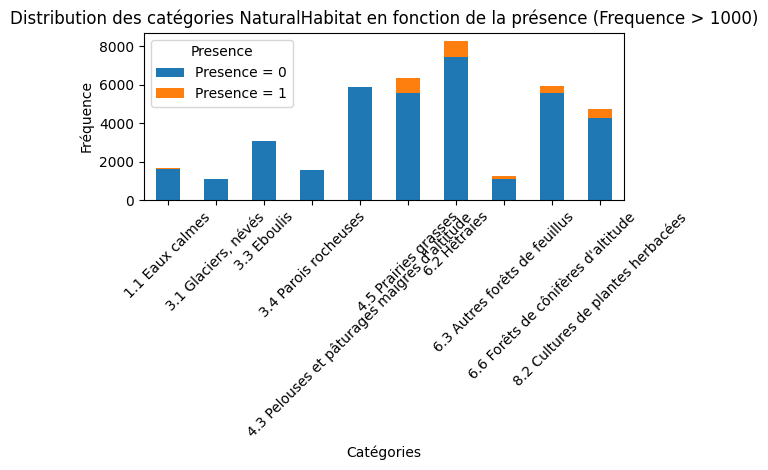

In [65]:
bar_plot_with_categories(gdf, translation, 'NaturalHabitat', 1000)

<Figure size 1000x700 with 0 Axes>

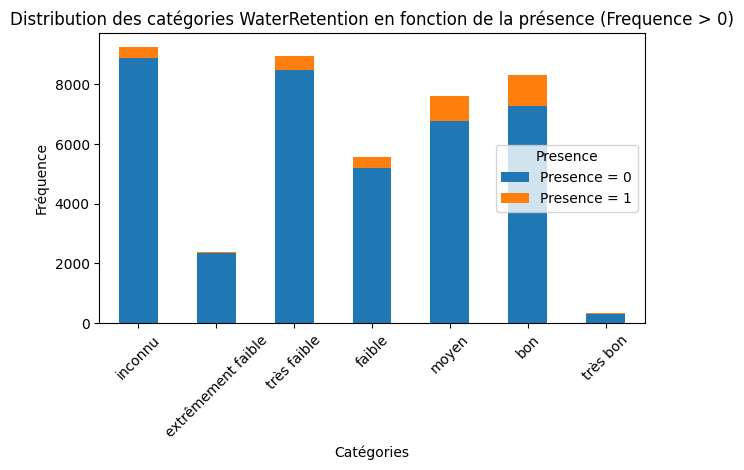

In [63]:
bar_plot_with_categories(gdf, translation, 'WaterRetention')

<Figure size 1000x700 with 0 Axes>

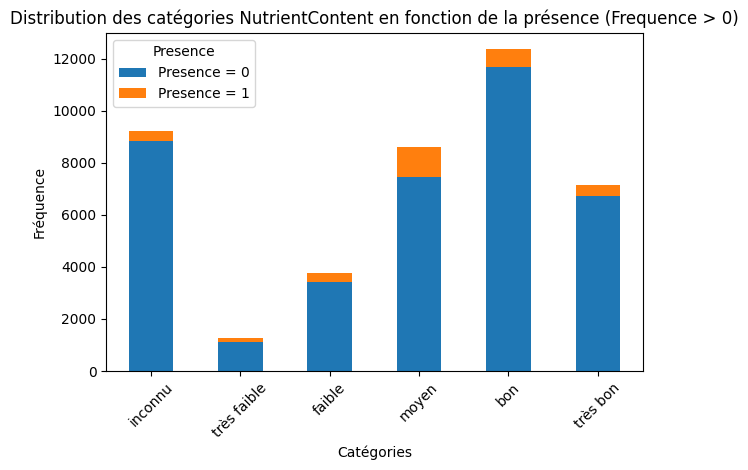

In [62]:
bar_plot_with_categories(gdf, translation, 'NutrientContent')